In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load dataset

In [2]:
dataset_path = "/kaggle/input/wildlife-animals-images"

In [3]:
def load_images_from_directory(base_path):
    image_data = {}
    
    for folder in os.listdir(base_path):
        if "-224" not in folder:
            continue
        
        folder_path = os.path.join(base_path, folder)
        
        subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
        if not subfolders:
            continue
        
        resize_folder_path = os.path.join(folder_path, subfolders[0])
        
        if os.path.isdir(resize_folder_path):
            image_data[folder] = []
            
            for file in os.listdir(resize_folder_path):
                file_path = os.path.join(resize_folder_path, file)
                
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(file_path)
                    if img is not None:
                        image_data[folder].append(img)
    
    return image_data

In [4]:
data = load_images_from_directory(dataset_path)

In [5]:
for category, imgs in data.items():
    print(f"{category}: {len(imgs)} images loaded")

fox-resize-224: 250 images loaded
lion-resize-224: 294 images loaded
hyena-resize-224: 305 images loaded
wolf-resize-224: 263 images loaded
tiger-resize-224: 269 images loaded
cheetah-resize-224: 342 images loaded


# Applying data augmentation

In [6]:
def random_rotation(image):
    angle = random.uniform(-30, 30)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def random_flip(image):
    flip_type = random.choice([-1, 0, 1])
    return cv2.flip(image, flip_type)

def random_brightness(image):
    factor = random.uniform(0.5, 1.5)
    return np.clip(image * factor, 0, 255).astype(np.uint8)

def augment_image(image):
    if random.random() > 0.5:
        image = random_rotation(image)
    if random.random() > 0.5:
        image = random_flip(image)
    if random.random() > 0.5:
        image = random_brightness(image)
    return image

In [7]:
for category, imgs in list(data.items()):
    augmented_images = []
    
    for img in imgs:
        augmented_images.append(augment_image(img))
    
    data[category].extend(augmented_images)

In [8]:
# Images after augmentation
for category, imgs in data.items():
    print(f"{category}: {len(imgs)} images loaded")

fox-resize-224: 500 images loaded
lion-resize-224: 588 images loaded
hyena-resize-224: 610 images loaded
wolf-resize-224: 526 images loaded
tiger-resize-224: 538 images loaded
cheetah-resize-224: 684 images loaded


# Visualizing images

In [9]:
def show_images(data):
    for category, imgs in data.items():
        print(f"{category}: {len(imgs)} images loaded")

        sample_images = imgs[:3]  

        fig, axes = plt.subplots(1, 3, figsize=(10, 3))
        fig.suptitle(f"Images - {category}", fontsize=14)
        
        for i, img in enumerate(sample_images):
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].axis('off') 
        
        for i in range(len(sample_images), 3):
            axes[i].axis('off')

        plt.show()

fox-resize-224: 500 images loaded


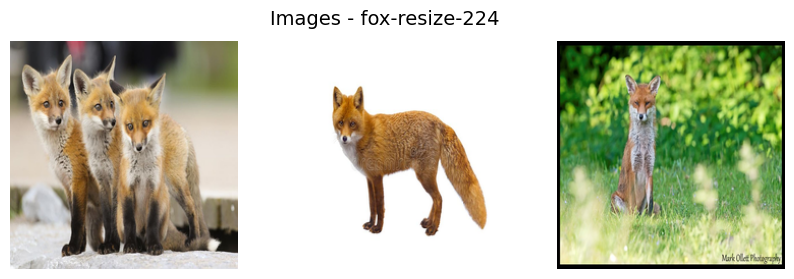

lion-resize-224: 588 images loaded


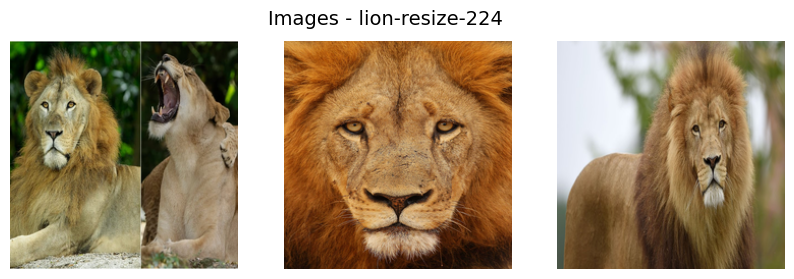

hyena-resize-224: 610 images loaded


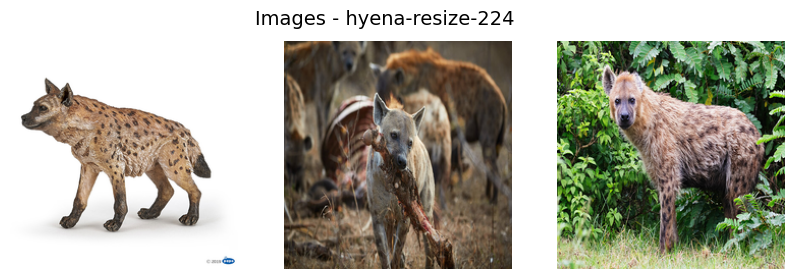

wolf-resize-224: 526 images loaded


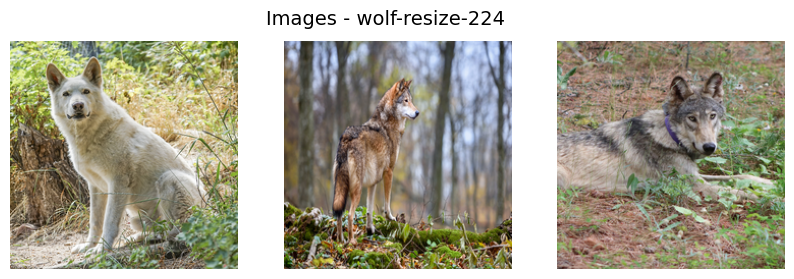

tiger-resize-224: 538 images loaded


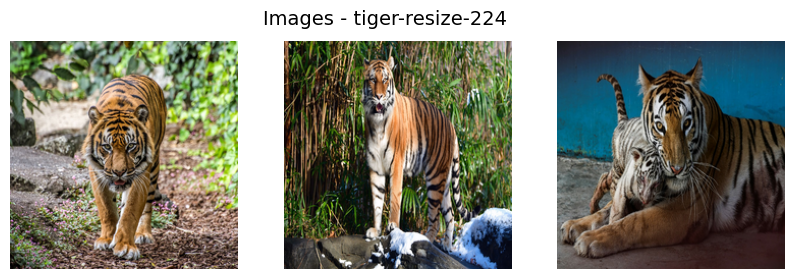

cheetah-resize-224: 684 images loaded


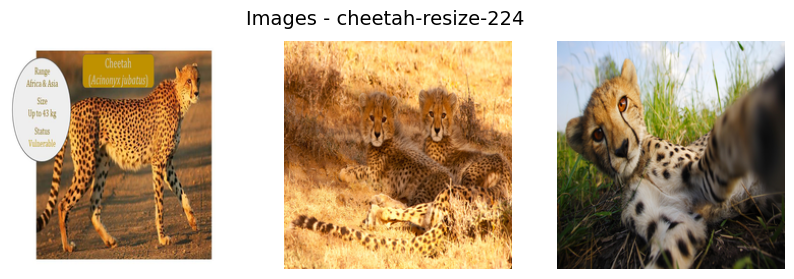

In [10]:
show_images(data)

# Preprocessing and Splitting Data

In [11]:
def split_data(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    train_data, val_data, test_data = {}, {}, {}

    for category, imgs in data.items():
        random.shuffle(imgs)
        
        train_imgs, temp_imgs = train_test_split(imgs, test_size=(val_ratio + test_ratio))
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (val_ratio + test_ratio))

        train_data[category] = train_imgs
        val_data[category] = val_imgs
        test_data[category] = test_imgs

    return train_data, val_data, test_data

In [12]:
def preprocess_images(image_list):
    return np.array([img.astype("float32") / 255.0 for img in image_list])

def split_and_prepare_data(data):
    train_data, val_data, test_data = split_data(data, train_ratio=0.85, val_ratio=0.1, test_ratio=0.05)

    train_data = {k: preprocess_images(v) for k, v in train_data.items()}
    val_data = {k: preprocess_images(v) for k, v in val_data.items()}
    test_data = {k: preprocess_images(v) for k, v in test_data.items()}

    return train_data, val_data, test_data

In [13]:
train_data, val_data, test_data = split_and_prepare_data(data)

In [14]:
print("Dataset split summary:")

print("\nTraining set:")
for category, imgs in train_data.items():
    print(f"{category}: {len(imgs)} images")

print("\nValidation set:")
for category, imgs in val_data.items():
    print(f"{category}: {len(imgs)} images")

print("\nTest set:")
for category, imgs in test_data.items():
    print(f"{category}: {len(imgs)} images")

Dataset split summary:

Training set:
fox-resize-224: 424 images
lion-resize-224: 499 images
hyena-resize-224: 518 images
wolf-resize-224: 447 images
tiger-resize-224: 457 images
cheetah-resize-224: 581 images

Validation set:
fox-resize-224: 50 images
lion-resize-224: 59 images
hyena-resize-224: 61 images
wolf-resize-224: 52 images
tiger-resize-224: 54 images
cheetah-resize-224: 68 images

Test set:
fox-resize-224: 26 images
lion-resize-224: 30 images
hyena-resize-224: 31 images
wolf-resize-224: 27 images
tiger-resize-224: 27 images
cheetah-resize-224: 35 images


# Converting data to numpy arrays & labels

In [15]:
def prepare_data_dict(data_dict):
    X, y = [], []
    for category, images in data_dict.items():
        label = category_to_label[category]
        for img in images:
            X.append(img)  
            y.append(label)
    
    X = np.array(X)
    y = to_categorical(np.array(y), num_classes=num_classes)
    
    return X, y

In [16]:
categories = list(train_data.keys())
num_classes = len(categories)
category_to_label = {category: i for i, category in enumerate(categories)}

In [17]:
X_train, y_train = prepare_data_dict(train_data)
X_val, y_val = prepare_data_dict(val_data)
X_test, y_test = prepare_data_dict(test_data)

In [18]:
print(f"Train shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Val shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test shape: {X_test.shape}, Labels shape: {y_test.shape}")

Train shape: (2926, 224, 224, 3), Labels shape: (2926, 6)
Val shape: (344, 224, 224, 3), Labels shape: (344, 6)
Test shape: (176, 224, 224, 3), Labels shape: (176, 6)


# Building CNN

In [22]:
from tensorflow.keras import Sequential
import tensorflow.keras.layers as tfl

In [66]:
model = Sequential([
    tfl.Input(shape=(224, 224, 3)),
    
    tfl.Conv2D(32, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),
    
    tfl.Conv2D(64, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),
    
    tfl.Conv2D(128, 3, activation='relu', padding='same'),
    tfl.Conv2D(128, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),

    tfl.Conv2D(256, 3, activation='relu', padding='same'),
    tfl.Conv2D(256, 3, activation='relu', padding='same'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),

    tfl.GlobalAveragePooling2D(),
    
    tfl.Dense(128, activation='relu'),
    tfl.Dropout(0.3),
    
    tfl.Dense(64, activation='relu'),
    tfl.Dropout(0.2),

    tfl.Dense(num_classes, activation='softmax'),
])

In [67]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │              

 Total params: 1,169,542 (4.46 MB)

 Trainable params: 1,168,582 (4.46 MB)

 Non-trainable params: 960 (3.75 KB)

In [69]:
history = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                   )

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.3140 - loss: 1.7166 - val_accuracy: 0.1860 - val_loss: 2.2255
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.4490 - loss: 1.3892 - val_accuracy: 0.1453 - val_loss: 2.2466
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.4782 - loss: 1.3040 - val_accuracy: 0.1977 - val_loss: 1.9817
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5529 - loss: 1.1718 - val_accuracy: 0.1773 - val_loss: 2.4159
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5732 - loss: 1.1179 - val_accuracy: 0.2529 - val_loss: 1.9693
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.6034 - loss: 1.0496 - val_accuracy: 0.4651 - val_loss: 1.4637
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.6581 - loss: 0.9510 - val_accuracy: 0.3430 - val_loss: 1.9049
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.6745 - loss: 0.8709 - val_accuracy: 0.5756 

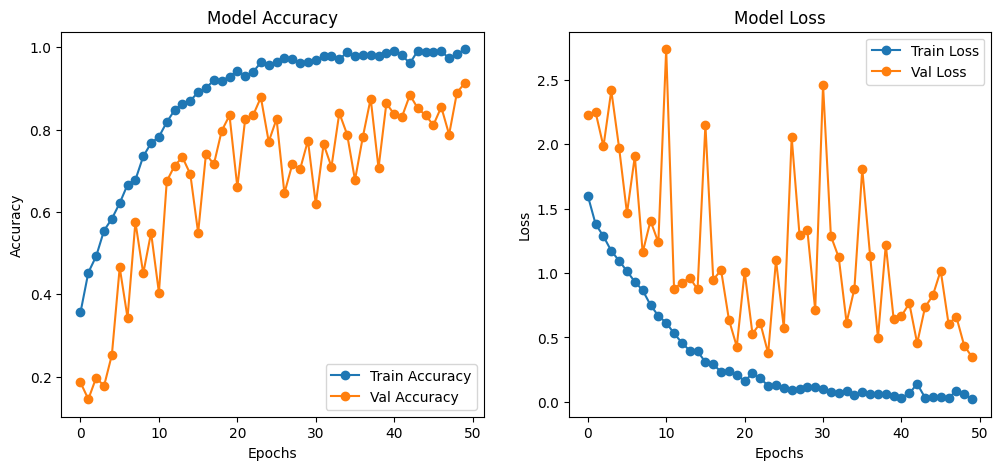

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
ax[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train Loss', marker='o')
ax[1].plot(history.history['val_loss'], label='Val Loss', marker='o')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

In [71]:
eval_res = model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.9114 - loss: 0.3791


In [72]:
print(eval_res)

[0.32832929491996765, 0.9147727489471436]


In [43]:
from sklearn.metrics import classification_report

In [73]:
y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

if y_test.shape[-1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


In [48]:
# fox-resize-224: 424 images
# lion-resize-224: 499 images
# hyena-resize-224: 518 images
# wolf-resize-224: 447 images
# tiger-resize-224: 457 images
# cheetah-resize-224: 581 images


class_names = ['Fox', 'Lion', 'Hyena', 'Wolf', 'Tiger', 'Cheetah']

In [74]:
report = classification_report(y_test_labels, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

         Fox       0.92      0.92      0.92        26
        Lion       0.88      0.93      0.90        30
       Hyena       0.79      0.87      0.83        31
        Wolf       0.92      0.81      0.86        27
       Tiger       1.00      1.00      1.00        27
     Cheetah       1.00      0.94      0.97        35

    accuracy                           0.91       176
   macro avg       0.92      0.91      0.92       176
weighted avg       0.92      0.91      0.92       176



In [76]:
from IPython.display import FileLink
model.save('/kaggle/working/wildlife_classifier_V1.h5')
FileLink('/kaggle/working/wildlife_classifier_V1.h5')

/kaggle/working/wildlife_classifier_V1.h5